<a href="https://colab.research.google.com/github/chasubeen/ML_lab/blob/main/3_HMM_BW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# **1. Preprocessing**

## **1-1. Load data**
- CoNLL-2000 file을 읽어와 word($\mathbf x$)와 tag($\mathbf z$) 처리

In [ ]:
# data path

train_path = "./data/train.txt"
test_path = "./data/test.txt"

In [ ]:
### Read file

def read_file(path):
  with open(path, 'r') as file:
    raw = file.read().strip().split('\n\n')  # 문장 단위로 분할
  words, tags = [], []

  for sentence in raw:
    lines = sentence.strip().split('\n')  # 문장 내의 각 라인(단어) 처리
    for line in lines:
      parts = line.split()  # 열 분할

      if len(parts) == 3:
        word, pos, chunk = parts
        words.append(word.lower())  # 소문자로 변환
        tags.append(pos)

    # 문장의 끝이라면(단어가 없다면) EOS 태그 추가
    if words:
      words.append('eos')
      tags.append('<EOS>')

  return words, tags

In [ ]:
train_words, train_tags = read_file(train_path)
test_words, test_tags = read_file(test_path)

## **1-2. Preprocess Data**

### **a) 특수 문자 처리**
- 숫자 태그를 'NUM'으로 변경
- 빈 문자열 제거

In [ ]:
def preprocessing(words, tags):
  processed_words = []
  processed_tags = []

  for word, tag in zip(words, tags):

    # 모든 숫자의 tag는 'NUM'으로 대체
    if re.match(r'^[0-9]*$', word):
      tag = 'NUM'

    # 빈 문자열이 아닌 경우에만 추가
    if word.strip():
      processed_words.append(word.lower())  # 소문자 변환
      processed_tags.append(tag)

  return processed_words, processed_tags

In [ ]:
train_words, train_tags = preprocessing(train_words, train_tags)
test_words, test_tags = preprocessing(test_words, test_tags)

### **b) POS Tag 통합**
- 영어의 대표적인 **8품사(+ 접속사, 숫자)**만 남기고, 나머지는 기타로 처리

In [ ]:
def modify_tags(tags):
    tag_map = {
        'NN': 'N', 'NNS': 'N', 'NNP': 'N', 'NNPS': 'N',
        'VB': 'V', 'VBD': 'V', 'VBG': 'V', 'VBN': 'V', 'VBP': 'V', 'VBZ': 'V',
        'PRP': 'PN', 'PRP$': 'PN',
        'IN': 'PP',
        'RB': 'AD', 'RBR': 'AD', 'RBS': 'AD', 'WRB': 'AD',
        'CC': 'CONJ',
        'DT': 'ART', 'PDT': 'ART',
        'JJ': 'AdJ', 'JJR': 'AdJ', 'JJS': 'AdJ',
        'NUM': 'NUM',
        '<EOS>': '<EOS>'
    }
    return [tag_map.get(tag, 'ETC') for tag in tags]

In [ ]:
train_tags = modify_tags(train_tags)
test_tags = modify_tags(test_tags)

In [ ]:
print(len(set(train_tags)))
print(len(set(test_tags)))

11
11


In [ ]:
set(train_tags)

{'<EOS>', 'AD', 'ART', 'AdJ', 'CONJ', 'ETC', 'N', 'NUM', 'PN', 'PP', 'V'}

> **11**개의 tag(품사)로 잘 정리된 것을 확인할 수 있다.

### **c) 단어 사전 생성**
- 태그와 단어들을 인덱스로 매핑하는 사전 생성

In [ ]:
def make_dict(tags, words):
  tag_to_index = {tag: idx for idx, tag in enumerate(set(tags))}
  word_to_index = {word: idx for idx, word in enumerate(set(words))}
  return tag_to_index, word_to_index

In [ ]:
tag_to_index, vocab_to_index = make_dict(train_tags, train_words)

In [ ]:
# UNK(Unknown) 추가
vocab_to_index['UNK'] = len(vocab_to_index)

### **d) index 변환**

In [ ]:
def to_indices(objs, obj_to_idx):
  return [obj_to_idx.get(obj, obj_to_idx['UNK']) for obj in objs]

In [ ]:
train_data_idx = to_indices(train_words, vocab_to_index)
train_tag_idx = [tag_to_index[tag] for tag in train_tags]

In [ ]:
test_data_idx = to_indices(test_words, vocab_to_index)
test_tag_idx = [tag_to_index[tag] for tag in test_tags]

## **1-3. 최종 데이터 확인**

In [ ]:
print(train_tags[:40])
print()
print(train_words[:40])

['N', 'PP', 'ART', 'N', 'V', 'AD', 'V', 'ETC', 'V', 'ART', 'AdJ', 'N', 'PP', 'N', 'N', 'PP', 'N', 'ETC', 'AdJ', 'PP', 'N', 'N', 'ETC', 'V', 'ETC', 'V', 'ART', 'AdJ', 'N', 'PP', 'N', 'CONJ', 'N', 'ETC', 'AdJ', 'N', 'ETC', '<EOS>', 'N', 'PP']

['confidence', 'in', 'the', 'pound', 'is', 'widely', 'expected', 'to', 'take', 'another', 'sharp', 'dive', 'if', 'trade', 'figures', 'for', 'september', ',', 'due', 'for', 'release', 'tomorrow', ',', 'fail', 'to', 'show', 'a', 'substantial', 'improvement', 'from', 'july', 'and', 'august', "'s", 'near-record', 'deficits', '.', 'eos', 'chancellor', 'of']


# **2. Modeling**

In [ ]:
class HMM_BW:
  def __init__(self, num_states, vocab_size):
    self.n_states = num_states
    self.vocab_size = vocab_size

    ## Initialization
    # 모두 동일한 확률로 초기화
    self.pi = np.random.rand(self.n_states)  # initial state probabilities
    self.pi /= self.pi.sum()

    self.A = np.random.rand(self.n_states, self.n_states)   # transition probabilities
    self.A /= self.A.sum(axis = 1, keepdims = True)

    self.B = np.random.rand(self.n_states, self.vocab_size)   # emission probabilities
    self.B /= self.B.sum(axis = 1, keepdims = True)

  def forward(self, X):
    T = len(X) # 전체 단어 개수(= time step)
    alpha = np.zeros((T, self.n_states))

    # Initial condition
    alpha[0] = self.pi * self.B[:, X[0]]
    alpha[0] /= np.sum(alpha[0]) if np.sum(alpha[0]) != 0 else 1e-10

    # Recursion
    for t in range(1, T):
      alpha[t] = self.B[:, X[t]] * np.dot(alpha[t-1], self.A)
      alpha[t] /= np.sum(alpha[t]) if np.sum(alpha[t]) != 0 else 1e-10
    return alpha

  def backward(self, X):
    T = len(X)
    beta = np.zeros((T, self.n_states))

    # Initial condition
    beta[- 1] = 1

    # Recursion
    for t in range(T-2, -1, -1):
      beta[t] = np.dot((beta[t+1] * self.B[:, X[t+1]]), self.A)
      beta[t] /= np.sum(beta[t]) if np.sum(beta[t]) != 0 else 1e-10

    return beta

  def calculate_gamma(self, alpha, beta):
    gamma = alpha * beta
    gamma /= np.sum(gamma, axis=1, keepdims=True) + 1e-10
    return gamma

  def calculate_xi(self, X, alpha, beta):
    T = len(X)
    xi = np.zeros((T - 1, self.n_states, self.n_states))

    for t in range(T - 1):
      denominator = np.sum(alpha[t] * np.dot(self.A, self.B[:, X[t + 1]] * beta[t + 1]))
      denominator = denominator if denominator != 0 else 1e-10

      xi[t] = alpha[t][:, None] * self.B[:, X[t + 1]] * self.A * beta[t + 1] / denominator

    return xi

  def e_step(self, X):
    # Forward와 Backward 알고리즘으로 alpha, beta 계산
    alpha = self.forward(X)
    beta = self.backward(X)

    # Gamma와 Xi 계산
    gamma = self.calculate_gamma(alpha, beta)
    xi = self.calculate_xi(X, alpha, beta)

    return gamma, xi

  def m_step(self, X, gamma, xi):
    # Initial state probabilities
    self.pi = gamma[0] / (np.sum(gamma[0]) + 1e-10)

    # Transition probabilities
    self.A = np.sum(xi, axis=0) / (np.sum(gamma[:-1], axis=0, keepdims=True) + 1e-10)

    # Emission probabilities
    for k in range(self.vocab_size):
      mask = (np.array(X) == k)
      if mask.sum() == 0:
        self.B[:, k] = 1e-10  # 수치적 안정성을 위해 매우 작은 값 부여
      else:
        self.B[:, k] = np.sum(gamma[mask], axis=0) / np.sum(gamma, axis=0)

  def compute_log_likelihood(self, X, gamma, xi):
    Q = 0
    T = len(X)

    # (1)
    Q += np.sum(gamma[0] * np.log(self.pi + 1e-10))
    # (2)
    for t in range(1, T):
      Q += np.sum(xi[t - 1] * np.log(self.A + 1e-10))
    # (3)
    for t in range(T):
      Q += np.sum(gamma[t] * np.log(self.B[:, X[t]] + 1e-10))

    return Q

  def fit(self, X, max_iter=100, tolerance=1e-6, patience=5):
    prev_log_likelihood = -np.inf
    patience_counter = 0
    log_likelihoods = []

    for iteration in range(max_iter):
      gamma, xi = self.e_step(X)
      self.m_step(X, gamma, xi)

      log_likelihood = self.compute_log_likelihood(X, gamma, xi)
      log_likelihoods.append(log_likelihood)
      print(f"Iteration {iteration + 1}: Log Likelihood = {log_likelihood:.4f}")

      ## Early Stopping
      if (log_likelihood - prev_log_likelihood) < tolerance:
        cnt += 1
      else:
        cnt = 0

      if patience_counter >= patience:
        print(f"Early stopping at iteration {iteration + 1}")
        break

      prev_log_likelihood = log_likelihood

    return log_likelihoods

  def predict(self, X):
    T = len(X)
    V = np.zeros((T, self.n_states))
    state_idx = np.zeros((T, self.n_states), dtype=int)

    # 1. Initialization
    V[0] = self.pi * self.B[:, X[0]]

    # 2. Recursion
    for t in range(1, T):
      for j in range(self.n_states):
        prob = V[t-1] * self.A[:, j]
        V[t, j] = np.max(prob) * self.B[j, X[t]]
        state_idx[t, j] = np.argmax(prob)

    # 3. Traceback
    z = np.zeros(T, dtype=int)
    z[-1] = np.argmax(V[-1])

    for t in range(T-2, -1, -1):
      z[t] = state_idx[t+1, z[t+1]]

    return z

  def accuracy(self, predictions, true_states):
    return np.mean(predictions == true_states)

# **3. Training**

In [ ]:
num_states = len(tag_to_index)  # 품사 태그 개수
vocab_size = len(vocab_to_index)  # 단어 사전 크기

In [ ]:
# HMM 모델 학습

hmm_model = HMM_BW(num_states = num_states, vocab_size = vocab_size)
log_likelihoods = hmm_model.fit(train_data_idx, max_iter=50, patience=5, tolerance=1e-10)

Iteration 1: Log Likelihood = -1945614.9932
Iteration 2: Log Likelihood = -1943444.5569
Iteration 3: Log Likelihood = -1938615.9587
Iteration 4: Log Likelihood = -1930074.6240
Iteration 5: Log Likelihood = -1916222.5070
Iteration 6: Log Likelihood = -1895941.0057
Iteration 7: Log Likelihood = -1870075.4068
Iteration 8: Log Likelihood = -1840352.3119
Iteration 9: Log Likelihood = -1807500.7139
Iteration 10: Log Likelihood = -1771967.4508
Iteration 11: Log Likelihood = -1734548.2489
Iteration 12: Log Likelihood = -1696593.7037
Iteration 13: Log Likelihood = -1659811.4990
Iteration 14: Log Likelihood = -1625699.3295
Iteration 15: Log Likelihood = -1595419.7738
Iteration 16: Log Likelihood = -1569550.0972
Iteration 17: Log Likelihood = -1547918.7996
Iteration 18: Log Likelihood = -1529956.1502
Iteration 19: Log Likelihood = -1514949.0432
Iteration 20: Log Likelihood = -1502293.1505
Iteration 21: Log Likelihood = -1491379.3586
Iteration 22: Log Likelihood = -1481849.9804
Iteration 23: Log L

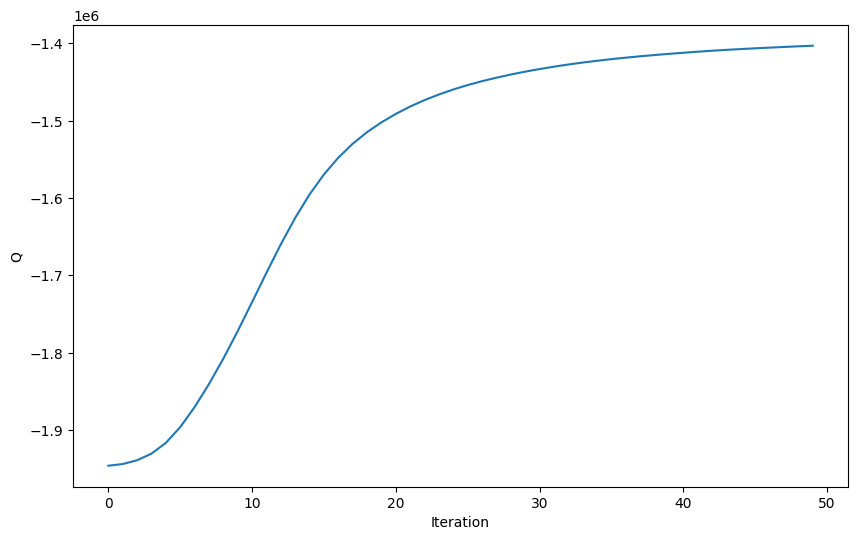

In [ ]:
# log-likelihood Plot

plt.figure(figsize=(10, 6))
plt.plot(log_likelihoods)
plt.xlabel('Iteration')
plt.ylabel('Q')
plt.show()

In [ ]:
# Train data에 대한 정확도 측정
train_predictions = hmm_model.predict(train_data_idx)
train_accuracy = hmm_model.accuracy(train_predictions, train_tag_idx)
print("Train Accuracy:", train_accuracy)

Train Accuracy: 0.040509736566619686


# **4. Testing**

In [ ]:
# Test data에 대한 정확도 측정
test_predictions = hmm_model.predict(test_data_idx)
test_accuracy = hmm_model.accuracy(test_predictions, test_tag_idx)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.04081880580696107


# **5. Results**

In [ ]:
def compare_result(words, true_tags, pred_indices, tag_to_idx):
  idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

  for word, true_tag, pred_idx in zip(words, true_tags, pred_indices):
    true_tag_label = true_tag if isinstance(true_tag, str) else idx_to_tag[true_tag]
    pred_tag_label = idx_to_tag[pred_idx]
    print(f"Word: {word:15} True Tag: {true_tag_label:10} Pred Tag: {pred_tag_label:10}")

In [ ]:
compare_result(test_words[:50], test_tag_idx[:50], test_predictions[:50], tag_to_index)

Word: rockwell        True Tag: N          Pred Tag: CONJ      
Word: international   True Tag: N          Pred Tag: <EOS>     
Word: corp.           True Tag: N          Pred Tag: AdJ       
Word: 's              True Tag: ETC        Pred Tag: <EOS>     
Word: tulsa           True Tag: N          Pred Tag: AdJ       
Word: unit            True Tag: N          Pred Tag: AD        
Word: said            True Tag: V          Pred Tag: ETC       
Word: it              True Tag: PN         Pred Tag: CONJ      
Word: signed          True Tag: V          Pred Tag: PN        
Word: a               True Tag: ART        Pred Tag: N         
Word: tentative       True Tag: AdJ        Pred Tag: AdJ       
Word: agreement       True Tag: N          Pred Tag: AdJ       
Word: extending       True Tag: V          Pred Tag: PN        
Word: its             True Tag: PN         Pred Tag: N         
Word: contract        True Tag: N          Pred Tag: AD        
Word: with            True Tag: PP      